# Research Question 2: How did the performance treatments influence the relevant metrics of the Climate Superemulator?
## RQ 2.3:  How does Brain Floating Point 16 (BFLOAT) Mixed Precision Training (MPT) influence Accuracy, Memory or Execution Time?

In [2]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install jinja2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
pip install pingouin

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import statistics


## Setup and Data Loading from Wandb

In [8]:
api = wandb.Api()

MPT = api.runs(f"causalpaca/emulator", filters = {'group' : "MPT", 'tags': "6_models"})
RTX8000 = api.runs(f"causalpaca/emulator", filters = {'group' : "Baseline", 'tags': "6_models"})
Treatment_Names = ["Baseline", "MPT"]
Treatments = [RTX8000,MPT]

print(len(MPT))
print(len(RTX8000))
if(len(MPT) ==len(RTX8000)):
    print("continue")
else: 
    print("A100 and Baseline do not have same amounts of runs!")


8
8
continue


In [38]:
def extract_parts_from_name(name):
    """
    Extracts parts from a given name.
    """
    parts = name.split('_')
    new_name = parts[1]
    if(parts[2]=="frozen"):
      new_name = new_name +"_"+ parts[2]
    return new_name

def filter_system_metrics(system_metrics, filter_criteria):
    """
    Filters system metrics based on specified criteria.
    """
    filtered_columns = [metric[0] for metric in filter_criteria]

    return system_metrics[filtered_columns]


data = []
for index, treatment in enumerate(Treatments):

  for model in treatment:
      # Fetching metrics for the specified run
      print(model.summary)
      name = extract_parts_from_name(model.name)

      # Retrieving system metrics history
      system_metrics = model.history(stream="systemMetrics")
      filter_criteria = [
          ['system.cpu'],
          ['system.gpu.process.0.gpu'],
          ['system.gpu.process.0.memoryAllocatedBytes'],
          ['system.proc.memory.rssMB'],
          ['system.memory']
      ]
      # Filtering system metrics based on the specified criteria
      system_metrics_filtered = filter_system_metrics(system_metrics, filter_criteria)

      defaults = model.history()

      # Scanning history for default metrics
      still_running = False


      time = model.summary["_wandb"].runtime/60 # in minutes
      emissions = model.summary["emissions"]
      default_metrics = model.history(stream="default",pandas=True)
      train_time = default_metrics["time/train"].dropna().to_numpy()
      epoch = default_metrics["epoch"].dropna().to_numpy()
      accuracy = default_metrics["val/rmse"].dropna().to_numpy()
      steps = default_metrics['_step'].tolist()
      # Creating DataFrame for the filtered default metrics and steps
      #val_rmse_df = pd.DataFrame({'val/rmse': val_rmse}).fillna(method='ffill')

      # Extracting runtime values from system metrics
      runtime_values = system_metrics['_runtime']

      #print(name,Treatment_Names[index], len(steps),len(epoch))
      runtime_hours = model.summary["_wandb"].runtime / 60 / 60
      # Create a new DataFrame for the current row
      data.append({
        "treatment": Treatment_Names[index],
        "name": name,
        "Time/Train": train_time,
        "CPU": system_metrics_filtered['system.cpu'].dropna().to_list(),
        "GPU": system_metrics_filtered['system.gpu.process.0.gpu'].dropna().to_list(),
        "GPU-Memory in GB": [x / (1e9) for x in system_metrics_filtered['system.gpu.process.0.memoryAllocatedBytes'].dropna().to_list()],
        "RSS-Memory in GB": [x / (1000) for x in system_metrics_filtered['system.proc.memory.rssMB'].dropna().to_list()],
        "RMSE": accuracy,
        "Steps": steps,
        "mem": system_metrics_filtered['system.memory'].dropna().to_list(),
        "runtime_hours": runtime_hours,
        "Co2": emissions,
        "Epoch": epoch,
      })
      print(name, statistics.mean(train_time))
# Convert the list of dictionaries to a DataFrame


{'val/pr/nrmse_climate_bench': 19.520023345947266, 'test/ssp245_EC-Earth3/pr/rmse': 0.34913551807403564, 'test/ssp245_MPI-ESM1-2-HR/pr/rmse': 0.9159863591194152, 'test/ssp245_MPI-ESM1-2-HR/nrmse_s_climate_bench': 14.534039497375488, 'test/ssp245_BCC-CSM2-MR/pr/nrmse_s_climate_bench': 1.2956100702285769, 'test/ssp245_MPI-ESM1-2-HR/tas/nrmse_climate_bench': 'NaN', 'train/pr/loss': 0.17904603481292725, 'test/ssp245_MPI-ESM1-2-HR/mse': 1.79187273979187, 'test/ssp245_MPI-ESM1-2-HR/tas/mse': 0.9528416395187378, 'test/ssp245_FGOALS-f3-L/llmse_climax': 2.3840982913970947, 'test/ssp245_MPI-ESM1-2-HR/pr/llrmse_wheather_bench': 0.9082151651382446, 'trainer/global_step': 69700, 'test/ssp245_BCC-CSM2-MR/pr/mse': 0.05202962085604668, 'test/ssp245_MPI-ESM1-2-HR/llmse_climax': 2.135615587234497, 'val/pr/nrmse_g_climate_bench': 3.3369593620300293, 'test/ssp245_EC-Earth3/pr/nrmse_climate_bench': 30.575483322143555, 'test/ssp245_EC-Earth3/rmse': 0.7039393186569214, 'test/ssp245_AWI-CM-1-1-MR/pr/mse': 0.2

In [23]:
runs_count = {}
for d in data:
    key = (d["name"], d["treatment"])
    runs_count[key] = runs_count.get(key, 0) + 1
print(runs_count)

{('unet', 'Baseline'): 2, ('convlstm', 'Baseline'): 2, ('climax_frozen', 'Baseline'): 2, ('climax', 'Baseline'): 2, ('unet', 'MPT'): 2, ('convlstm', 'MPT'): 2, ('climax_frozen', 'MPT'): 2, ('climax', 'MPT'): 2}


In [39]:
# Merge the Multiples
mean_data = {}
data_scheme={
    "CPU": [],
    "GPU": [],
    "RSS-Memory in GB": [],
    "RMSE": 0,
    "Steps": [],
    "runtime_hours": 0,
    "Co2": 0
}

for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    print(number_runs)
    print()
    print(run[0],run[1])
    CPU_Lists=[]
    GPU_Lists=[]
    RSS_Lists=[]
    RMSE_Lists=[]
    mem_lst = []
    Steps_Lists=[]
    Runtime_Lists=[]
    Time_train_list = []
    CO2_Lists=[]
    GPU_Mem_List = []
    for d in data: 
        if d["name"] == run[0] and d["treatment"] == run[1]:
            CPU_Lists.append(d["CPU"])
            GPU_Lists.append(d["GPU"])
            RSS_Lists.append(d["RSS-Memory in GB"])
            RMSE_Lists.append(d["RMSE"])
            GPU_Mem_List.append(d["GPU-Memory in GB"])
            mem_lst.append(d["mem"])
            Steps_Lists.append(d["Steps"])
            Runtime_Lists.append(d["runtime_hours"])
            CO2_Lists.append(d["Co2"])
            Time_train_list.append(d["Time/Train"])
    
    if (number_runs>=2):
        mean_data[(run[0], run[1])] = {
            "time/train": [(x + y)/2 for x, y in zip(Time_train_list[0], Time_train_list[1])],
            "CPU": [(x + y)/2 for x, y in zip(CPU_Lists[0], CPU_Lists[1])],
            "GPU": [(x + y)/2 for x, y in zip(GPU_Lists[0], GPU_Lists[1])],
            "RSS-Memory in GB": [(x + y)/2 for x, y in zip(RSS_Lists[0], RSS_Lists[1])],
            "GPU-Memory in GB":[(x + y)/2 for x, y in zip(GPU_Mem_List[0], GPU_Mem_List[1])],
            "RMSE":  [(x + y)/2 for x, y in zip(RMSE_Lists[0], RMSE_Lists[1])],
            "mem":  [(x + y)/2 for x, y in zip(mem_lst[0], mem_lst[1])],
            "Steps": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
            "runtime_hours": statistics.mean(Runtime_Lists),
            "Co2": statistics.mean(CO2_Lists)
        }
    else:
        print("skipped")

print(mean_data)

2

unet Baseline
2

convlstm Baseline
2

climax_frozen Baseline
2

climax Baseline
2

unet MPT
2

convlstm MPT
2

climax_frozen MPT
2

climax MPT
{('unet', 'Baseline'): {'time/train': [48.61137771606445, 47.535409927368164, 46.7816104888916, 47.285287857055664, 47.22153091430664, 46.68802070617676, 47.5052604675293, 47.2622013092041, 46.92147445678711, 47.25473213195801, 46.73637580871582, 46.782161712646484, 46.696184158325195, 46.835628509521484, 46.854867935180664, 47.06068229675293, 46.57297134399414, 47.52988052368164, 47.21987724304199, 47.22931671142578, 46.842355728149414, 46.88558006286621, 46.8356819152832, 46.88877487182617, 47.31212615966797, 46.613351821899414, 46.65846633911133, 46.90234375], 'CPU': [1.5150000000000001, 2.935, 3.0149999999999997, 3.05, 2.88, 2.98, 2.9450000000000003, 2.9400000000000004, 3.0, 2.9050000000000002, 2.9850000000000003, 2.975, 2.8899999999999997, 2.975, 2.94, 2.955, 3.025, 2.98, 2.99, 3.0149999999999997, 2.87, 2.995, 2.98, 2.9450000000000003, 2

In [12]:
a = mean_data.get(("unet", "MPT"),0)
statistics.mean(a["GPU"])

50.53190140845071

## Overview of Mean, Median and STD

In [46]:
data_scheme={
    "CPU": [],
    "GPU": [],
    "RSS-Memory in GB": [],
    "RMSE": 0,
    "Steps": [],
    "runtime_hours": 0,
    "Co2": 0
}

rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    if(number_runs>=2):
        name = run[0]
        treatment = run[1]
        data_for_run = mean_data.get((run[0], run[1]),0)
        new_row = {
            "Name":name, 
            "Treatment":treatment, 
            "CPU_Mean": statistics.mean(data_for_run["CPU"]), 
            "CPU_Median": statistics.median(data_for_run["CPU"]), 
            "CPU_STD": statistics.stdev(data_for_run["CPU"]), 
            "GPU_Mean": statistics.mean(data_for_run["GPU"]), 
            "GPU_Median": statistics.median(data_for_run["GPU"]), 
            "GPU_STD": statistics.stdev(data_for_run["GPU"]), 
            "Overall Memory Percent": statistics.mean(data_for_run["mem"]),
            "Time/Train Mean_Minutes": statistics.mean(data_for_run["time/train"])/60,
            "Time/Train Median_Minutes": statistics.median(data_for_run["time/train"])/60,
            "Time/Train STD_Minutes": statistics.stdev(data_for_run["time/train"])/60,
            "RSS-Memory_Mean": statistics.mean(data_for_run["RSS-Memory in GB"]), 
            "GPU-Memory_Mean": statistics.mean(data_for_run["GPU-Memory in GB"]), 
            "RSS-Memory_Median": statistics.median(data_for_run["RSS-Memory in GB"]), 
            "RSS-Memory_STD": statistics.stdev(data_for_run["RSS-Memory in GB"]), 
            "RMSE": min(data_for_run["RMSE"]), 
            "Min_RMSE": min(data_for_run["RMSE"]), 
            "runtime_hours": data_for_run["runtime_hours"], 
            "Co2": data_for_run["Co2"]}
        
        rows.append(new_row)


already_used_name=[]
scaling_factor_rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)

        new_row = {
            "Name":name, 
            "CPU_Mean": statistics.mean(data_for_run_1["CPU"])/statistics.mean(data_for_run_0["CPU"]), 
            "GPU_Mean": statistics.mean(data_for_run_1["GPU"])/statistics.mean(data_for_run_0["GPU"]), 
            "RSS-Memory_Mean": statistics.mean(data_for_run_1["RSS-Memory in GB"])/statistics.mean(data_for_run_0["RSS-Memory in GB"]), 
            "RMSE": statistics.mean(data_for_run_1["RMSE"])/statistics.mean(data_for_run_0["RMSE"]), 
            "Time_Trainn": statistics.mean(data_for_run_1["time/train"])/statistics.mean(data_for_run_0["time/train"]),
            "runtime_hours": data_for_run_1["runtime_hours"]/data_for_run_0["runtime_hours"], 
            "Co2": data_for_run_1["Co2"]/data_for_run_0["Co2"]}
        
        scaling_factor_rows.append(new_row)

new_df = pd.DataFrame(rows)
new_df_sf = pd.DataFrame(scaling_factor_rows)
sorted_df = new_df.sort_values(by='Name')
sorted_df_sf = new_df_sf.sort_values(by='Name')
def round_if_float(x):
    if isinstance(x, float):
        rounded_value = round(x, 3)
        return rounded_value
    return x
sorted_df = sorted_df.applymap(round_if_float)
sorted_df_sf = sorted_df_sf.applymap(round_if_float)
selected_column = ['Name', 'Treatment',"Time/Train Mean_Minutes", "RMSE"]
selected_column_0 = ['Name', 'Treatment',"CPU_Mean","GPU_Mean","RSS-Memory_Mean","GPU-Memory_Mean","runtime_hours","Overall Memory Percent","RMSE"]

selecteddf = sorted_df[selected_column_0].copy().to_latex(index=False,float_format="%.3f")
print(selecteddf)

latex_table = sorted_df.to_latex(index=False,float_format="%.3f")
latex_table_sf = sorted_df_sf.to_latex(index=False,float_format="%.3f")

print(latex_table)
print(latex_table_sf)



\begin{tabular}{llrrrrrrr}
\toprule
Name & Treatment & CPU_Mean & GPU_Mean & RSS-Memory_Mean & GPU-Memory_Mean & runtime_hours & Overall Memory Percent & RMSE \\
\midrule
climax & Baseline & 1.933 & 55.691 & 13.919 & 4.359 & 3.972 & 13.553 & 1.171 \\
climax & MPT & 0.537 & 18.402 & 19.806 & 4.524 & 3.075 & 11.271 & 1.183 \\
climax_frozen & Baseline & 2.108 & 48.207 & 14.699 & 2.725 & 2.822 & 15.831 & 0.632 \\
climax_frozen & MPT & 0.524 & 16.677 & 19.886 & 3.137 & 2.038 & 7.391 & 0.673 \\
convlstm & Baseline & 4.486 & 34.851 & 8.158 & 1.427 & 0.375 & 12.880 & 0.551 \\
convlstm & MPT & 1.058 & 32.922 & 9.983 & 1.830 & 0.316 & 7.349 & 0.555 \\
unet & Baseline & 2.943 & 85.362 & 6.914 & 2.689 & 1.332 & 12.307 & 1.241 \\
unet & MPT & 0.775 & 50.532 & 8.505 & 2.340 & 0.680 & 7.727 & 1.151 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrrrrrrrrrrrrrrrr}
\toprule
Name & Treatment & CPU_Mean & CPU_Median & CPU_STD & GPU_Mean & GPU_Median & GPU_STD & Overall Memory Percent & Time/Train Mean_

C:\Users\fe-na\AppData\Local\Temp\ipykernel_28576\1136029337.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df = sorted_df.applymap(round_if_float)
C:\Users\fe-na\AppData\Local\Temp\ipykernel_28576\1136029337.py:78: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df_sf = sorted_df_sf.applymap(round_if_float)


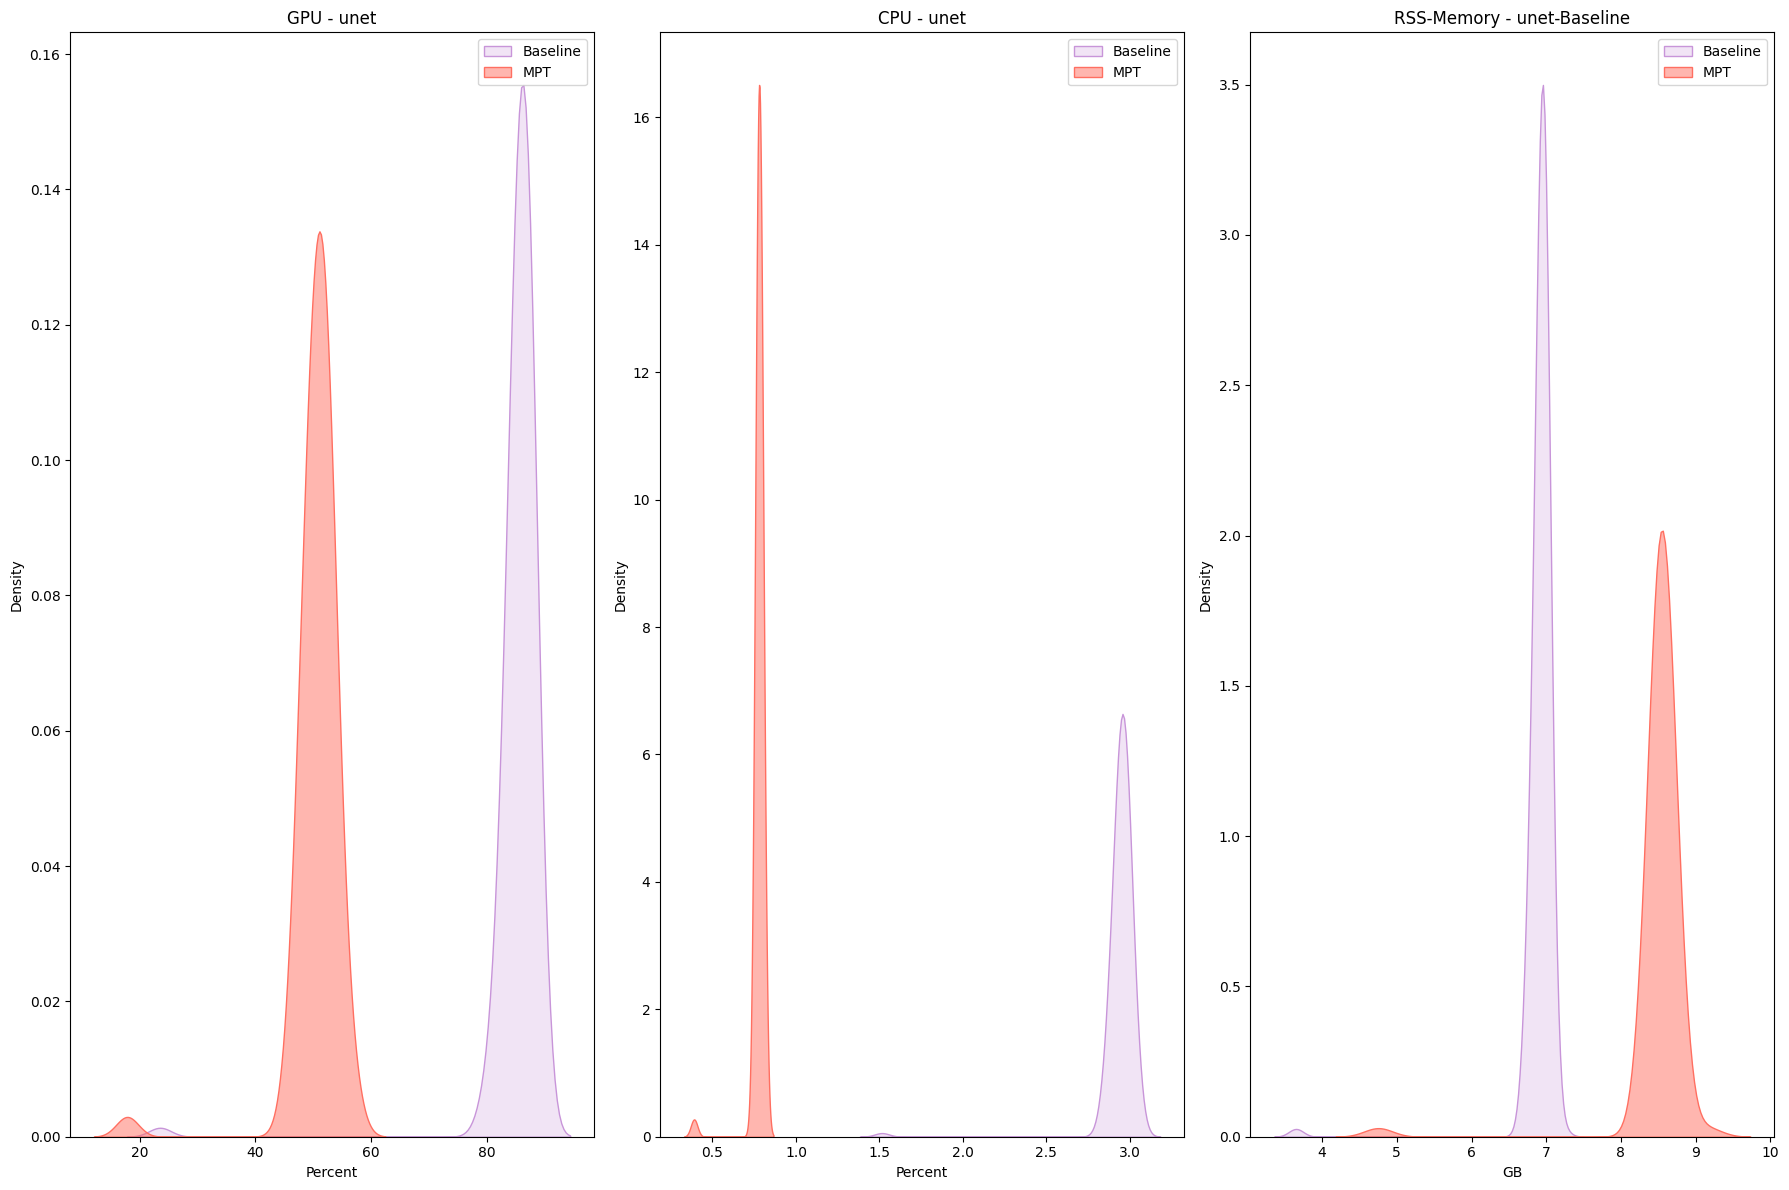

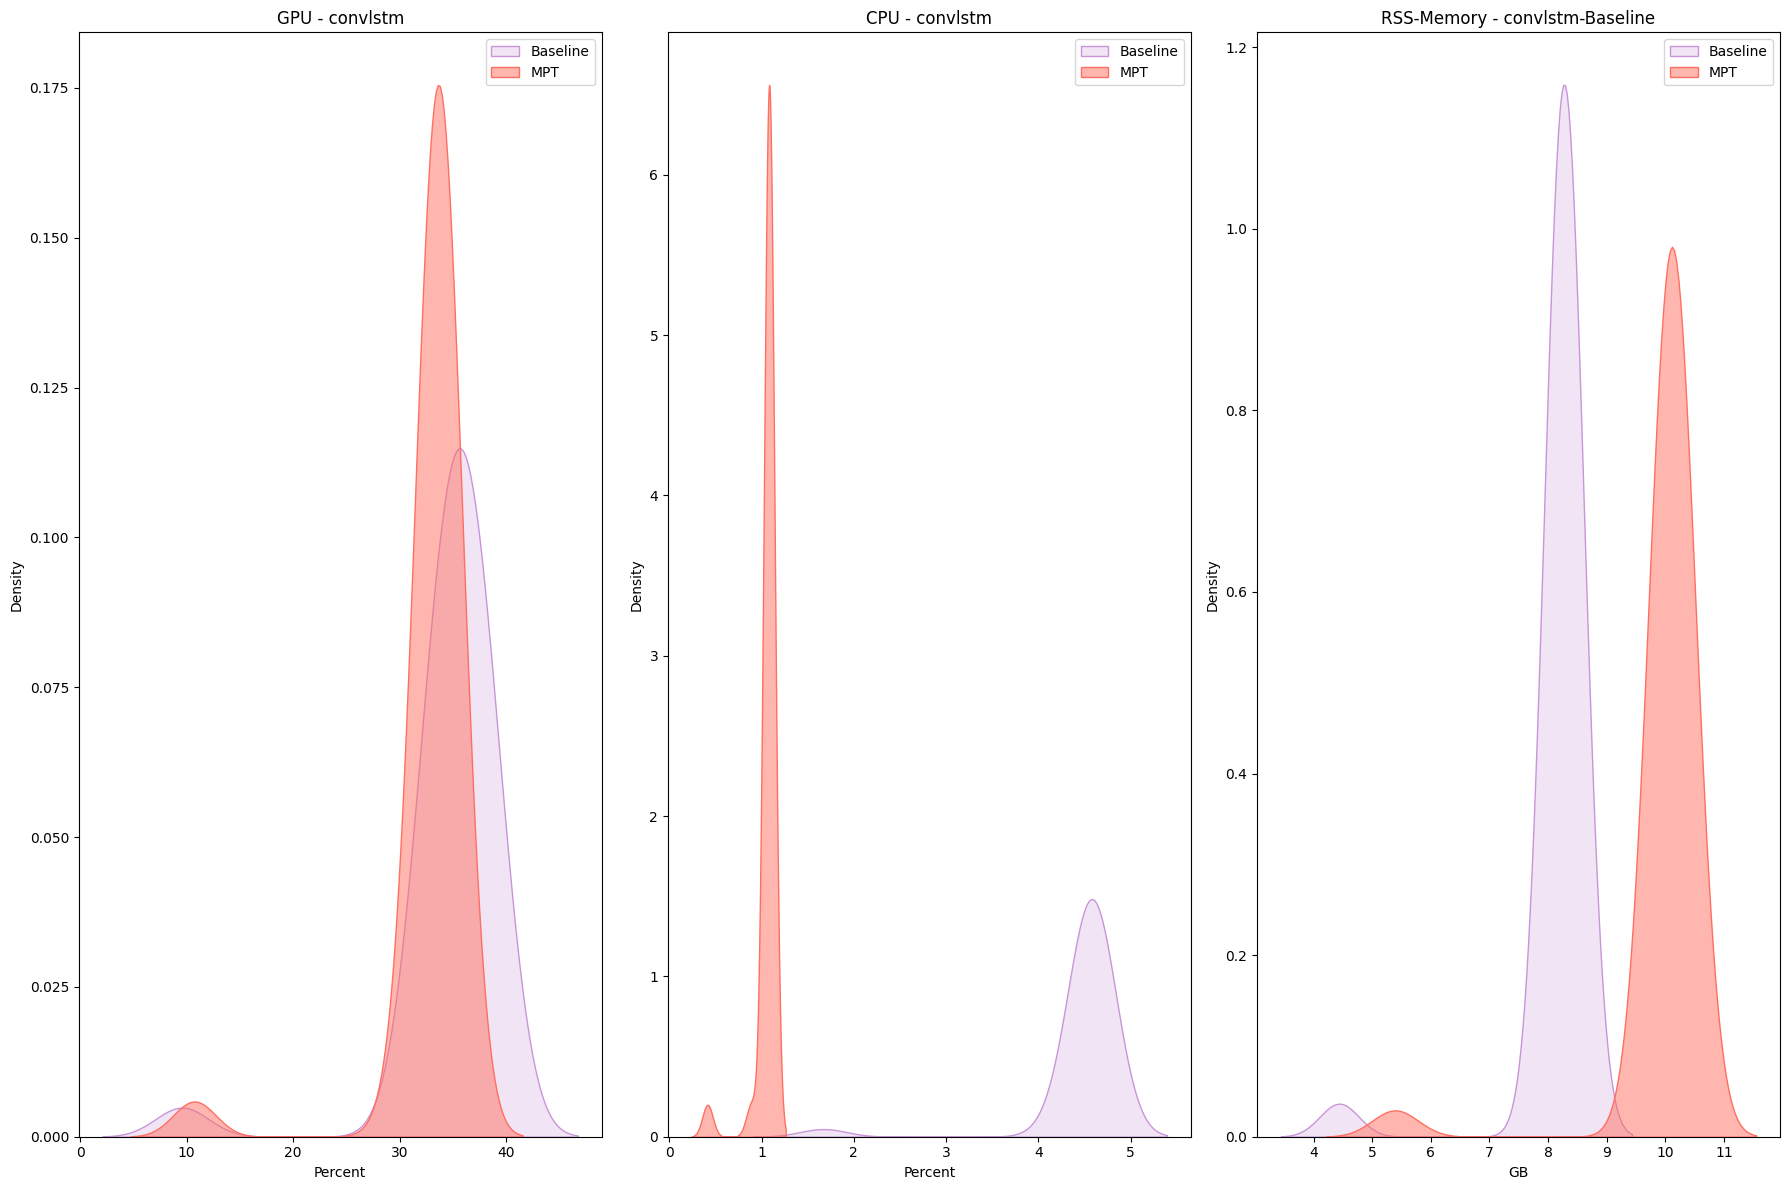

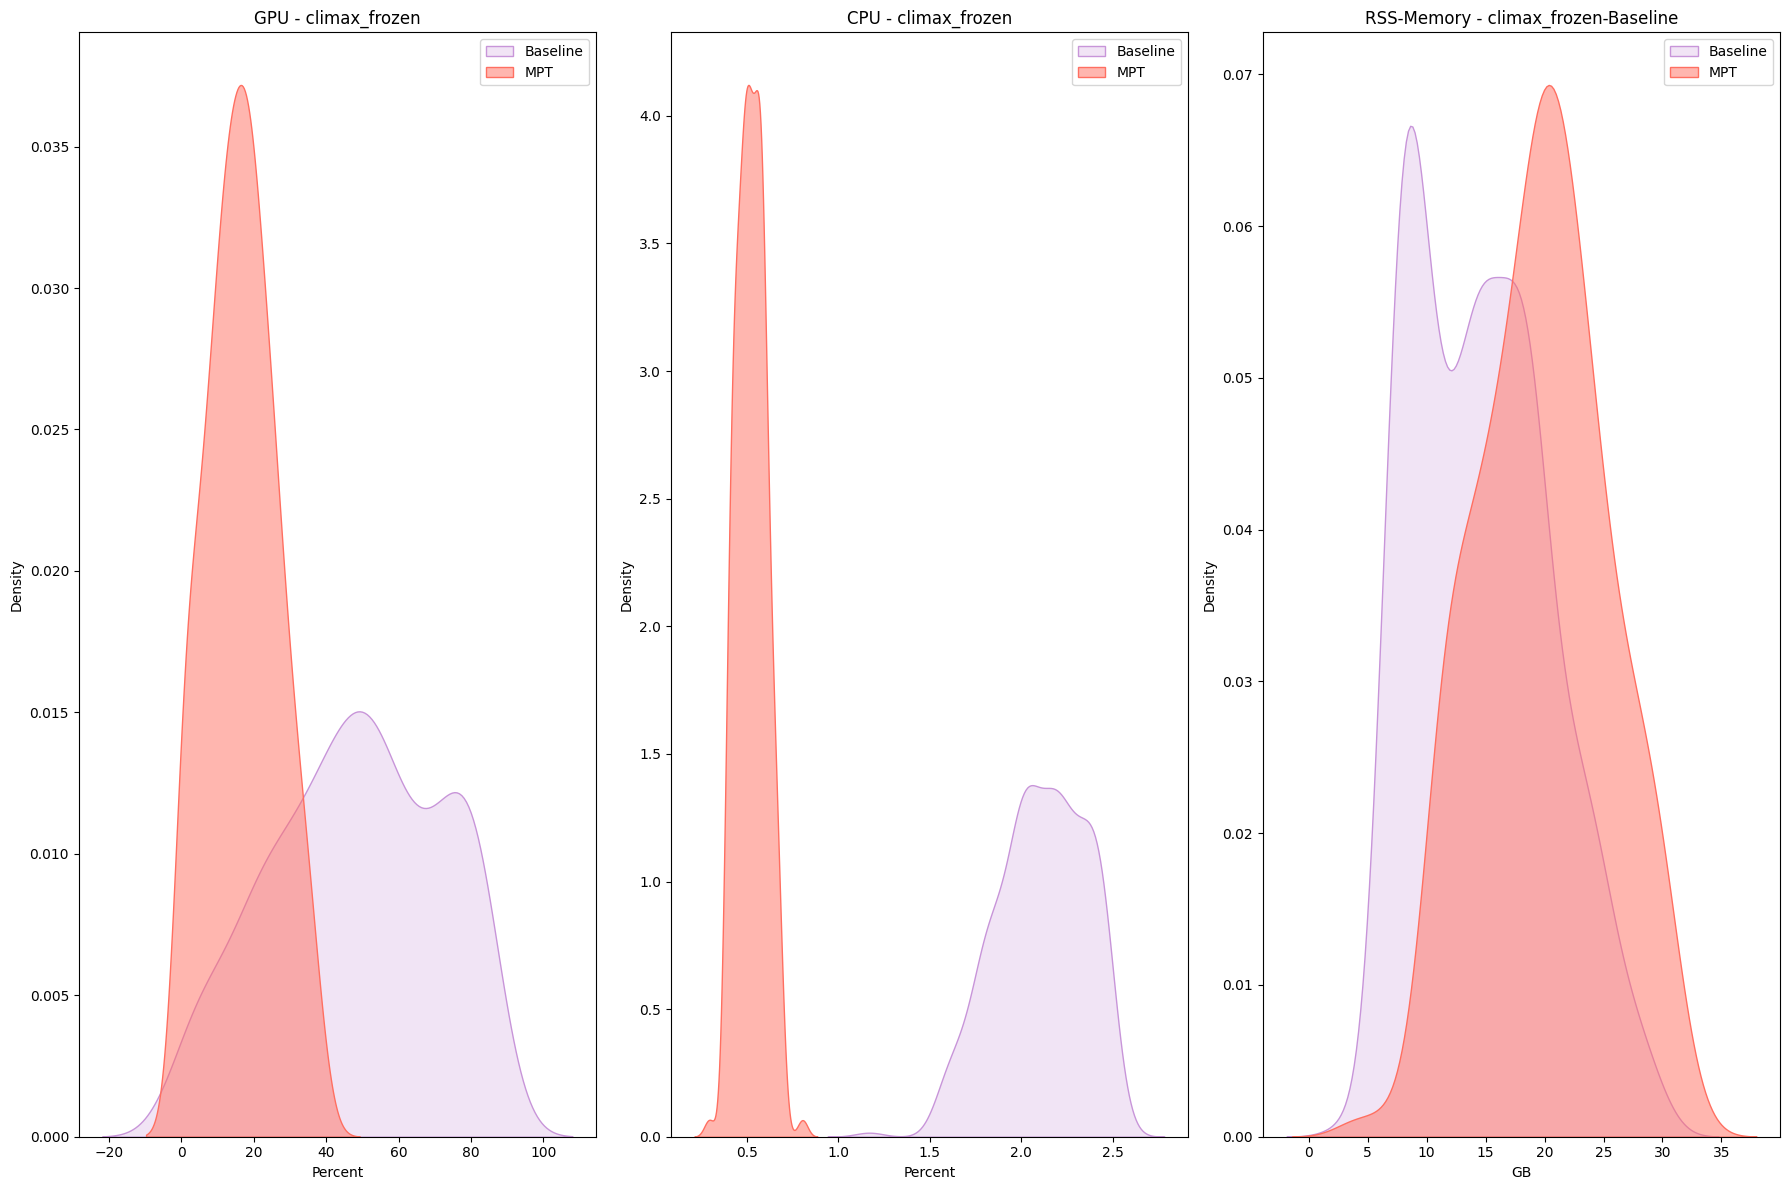

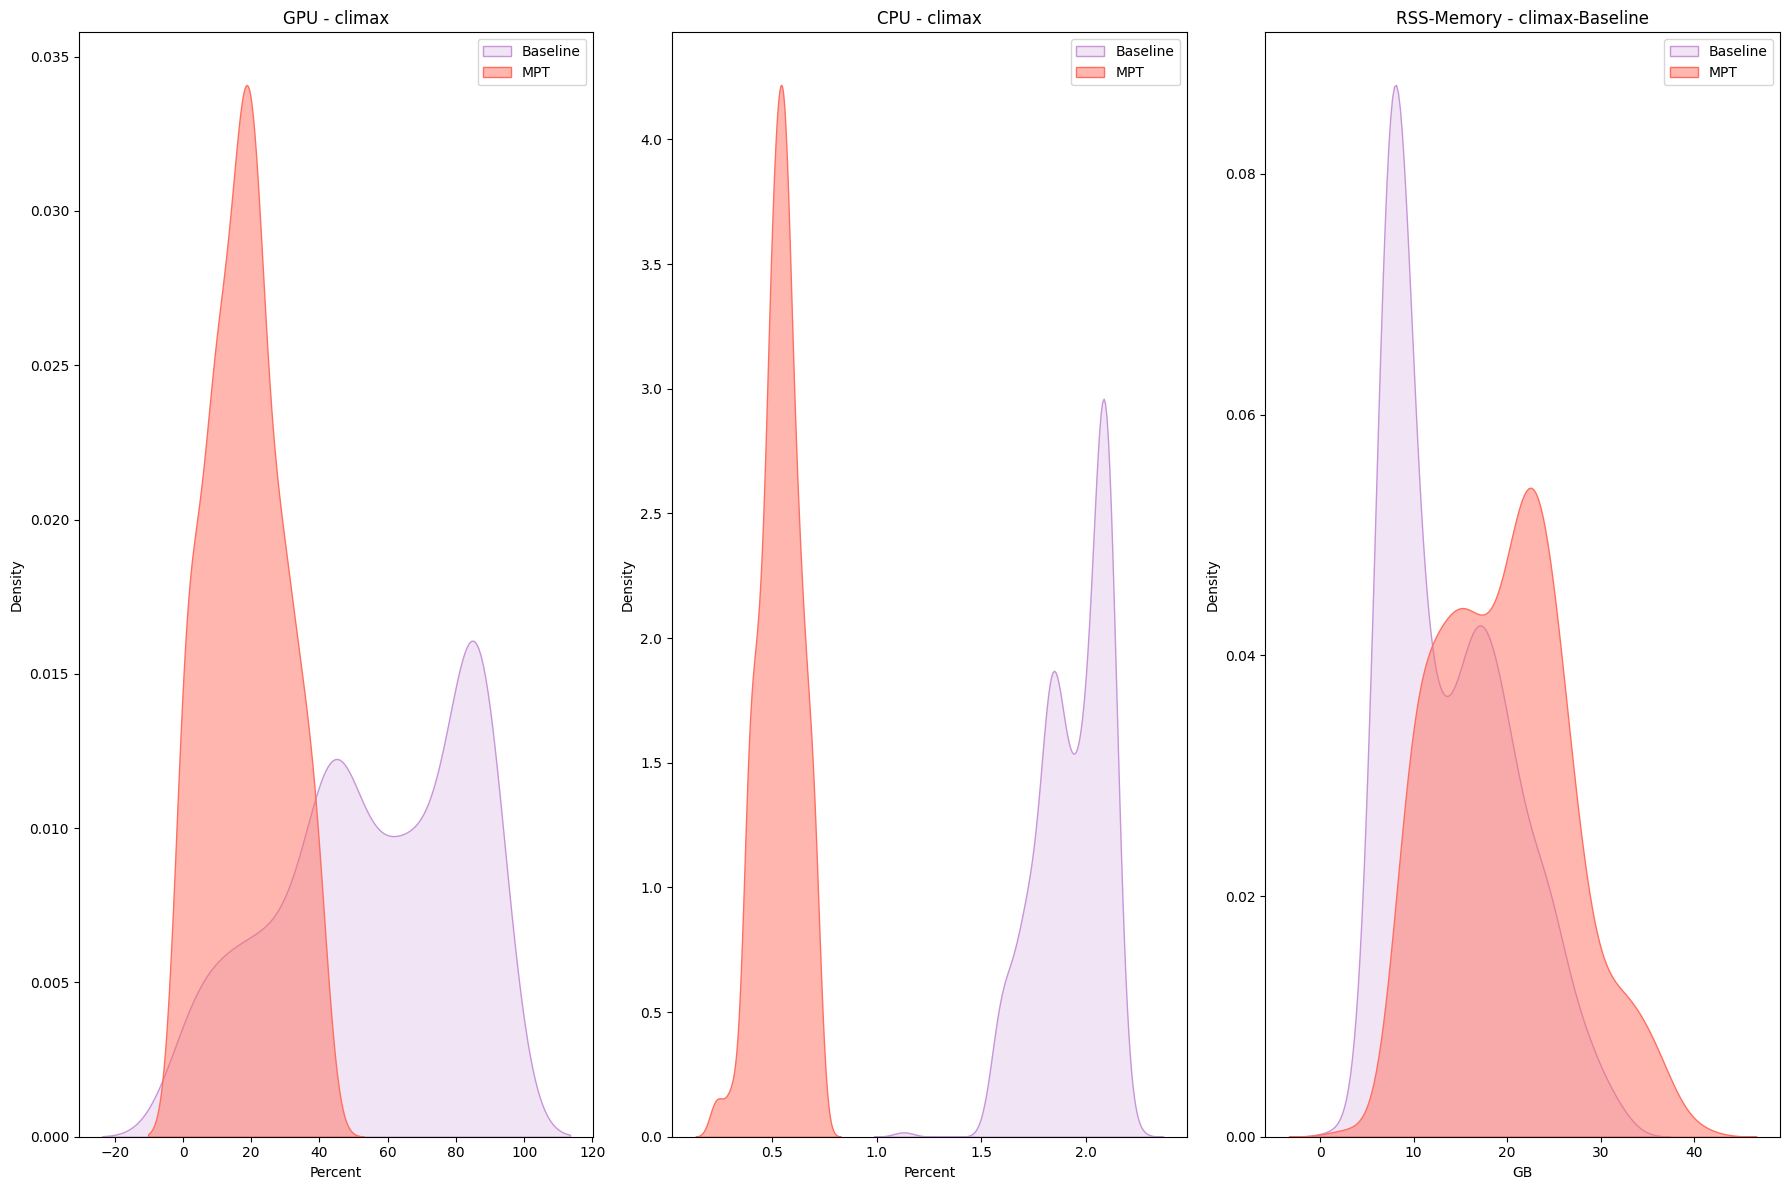

In [47]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from seaborn_qqplot import pplot
from scipy.stats import gamma
from PIL import Image
import statsmodels.api as sm 
import pylab as py 



def violin_plot(ax, data, name, unit):
    sns.violinplot(data=data, ax=ax, inner="box", color="#c895d9")
    ax.set_title(name)
    ax.set_xlabel("Data Distribution")
    ax.set_ylabel(unit)

def density_plot(ax, data, name, unit):
    sns.kdeplot(data=data, fill=True, color="#c895d9", ax=ax)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")


def qq_plot(ax, data, name, line_color="#c895d9"):
    # multirow = [{"Theoretical_Quantiles":np.array((stats.norm.ppf(np.arange(1, len(data)+1) / (len(data)+1))),dtype=float), "species":0}]
    # df = pd.DataFrame(multirow)
    # df_new = df.explode("Theoretical_Quantiles").astype(float)
    # # Plot the quantiles
    # pairGrid = pplot(df_new, x="Theoretical_Quantiles",y=gamma, kind='qq', height=5, aspect=1, display_kws={"identity":False, "fit":True, "reg":True, "ci":0.025})
    # pairGrid.add_legend(title=name)
    # pairGrid.figure.savefig(f"figures/{name}")
    # sm.qqplot(np.array(data), line ='45') 
    pp = sm.ProbPlot(np.array(data), fit=True)
    qq = pp.qqplot(ax=ax, marker='.', markerfacecolor='k', alpha=0.3, color='#1f77b4')
    sm.qqline(ax=ax, line='45', fmt='k--')
    ax.set_title(name)
    
    

def density_plot_2(ax, treatment_0, treatment_1,name_0,name_1, name, unit):
    sns.kdeplot(data=treatment_0, fill=True, color="#c895d9", ax=ax, label=name_0)
    sns.kdeplot(data=treatment_1, fill=True, color="#ff6f61", ax=ax, alpha=0.5, label=name_1)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")
    ax.legend()

def scale_down(data,factor=6.0):
    new_data = []
    for x in data:
        new_x = x / factor
        new_data.append(new_x)
    return new_data
        

############################################ VIOLIN & DENSITY PLOTS ############################################################

# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)
        
#         fig, axes = plt.subplots(1, 2, figsize=(18, 12))  # Create a 2x3 grid of subplots
#         if(run[1] != "Baseline"): 
#             violin_plot(axes[0], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#             # violin_plot(axes[0, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#             # violin_plot(axes[0, 2], data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
            
#             density_plot(axes[1], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#             # density_plot(axes[1, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#             # density_plot(axes[1, 2], data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
            
#             plt.tight_layout()
#             fig.savefig(f"figures/RQ_2.3_violin_density/RQ_2.3_violin_density_{name}-{treatment}.png")    

############################################ QQ PLOTS ############################################################
# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)

#         fig, axes = plt.subplots(1, 1, figsize=(15, 5),)  # Create a 2x3 grid of subplots
#         if(run[1] != "Baseline"): 
#             qq_plot(axes,data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}")
#             # qq_plot(axes[1],data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}")
#             # qq_plot(axes[2],data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}")

#             fig.savefig(f"figures/RQ_2.2_QQ/RQ_2_QQ_{name}-{treatment}")        
         # will now save all plots

############################################ COMBINED DENSITY PLOTS ############################################################


already_used_name=[]
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment = run[1]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)

        

        fig, axes = plt.subplots(1, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots

        density_plot_2(axes[0], data_for_run_0["GPU"],data_for_run_1["GPU"],treatment_0,treatment_1, f"GPU - {run[0]}", "Percent")
        density_plot_2(axes[1], data_for_run_0["CPU"],data_for_run_1["CPU"],treatment_0,treatment_1, f"CPU - {run[0]}", "Percent")
        density_plot_2(axes[2], data_for_run_0["RSS-Memory in GB"],data_for_run_1["RSS-Memory in GB"],treatment_0,treatment_1, f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
        plt.tight_layout()
        fig.savefig(f"figures/RQ_2.3_combined_density/{name}-{treatment}.png")        





In [48]:
from scipy import stats


data_list_shapiro = []

for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if number_runs >= 2:
        name = run[0]
        treatment = run[1]
        data_for_run = mean_data.get((run[0], run[1]), 0)
        
        SWT_GPU = stats.shapiro(data_for_run["CPU"])
        SWT_CPU = stats.shapiro(data_for_run["GPU"])
        SWT_RSS = stats.shapiro(data_for_run["RSS-Memory in GB"])
        
        data_list_shapiro.append({
            "Name": name,
            "Treatment": treatment,
            "GPU-Statistic": SWT_GPU.statistic,
            "GPU-P": SWT_GPU.pvalue,
            "CPU-Statistic": SWT_CPU.statistic,
            "CPU-P": SWT_CPU.pvalue,
            "RSS-Statistic": SWT_RSS.statistic,
            "RSS-P": SWT_RSS.pvalue
        })
        
df_Shapiro = pd.DataFrame(data_list_shapiro)
sorted_df_shapiro = df_Shapiro.sort_values(by='Name')
latex_table_shapiro = sorted_df_shapiro.to_latex(index=False)

print(latex_table_shapiro)
        

\begin{tabular}{llrrrrrr}
\toprule
Name & Treatment & GPU-Statistic & GPU-P & CPU-Statistic & CPU-P & RSS-Statistic & RSS-P \\
\midrule
climax & Baseline & 0.925048 & 0.000000 & 0.921616 & 0.000000 & 0.886803 & 0.000000 \\
climax & MPT & 0.985214 & 0.000925 & 0.974094 & 0.000006 & 0.974813 & 0.000006 \\
climax_frozen & Baseline & 0.971037 & 0.000003 & 0.965241 & 0.000000 & 0.949015 & 0.000000 \\
climax_frozen & MPT & 0.986047 & 0.025931 & 0.981554 & 0.005507 & 0.989672 & 0.104357 \\
convlstm & Baseline & 0.247946 & 0.000000 & 0.563709 & 0.000000 & 0.192415 & 0.000000 \\
convlstm & MPT & 0.241002 & 0.000000 & 0.367663 & 0.000000 & 0.184751 & 0.000000 \\
unet & Baseline & 0.293046 & 0.000000 & 0.281554 & 0.000000 & 0.165608 & 0.000000 \\
unet & MPT & 0.290579 & 0.000000 & 0.537420 & 0.000000 & 0.147144 & 0.000000 \\
\bottomrule
\end{tabular}



unet Baseline
unet MPT
158 73
158 158


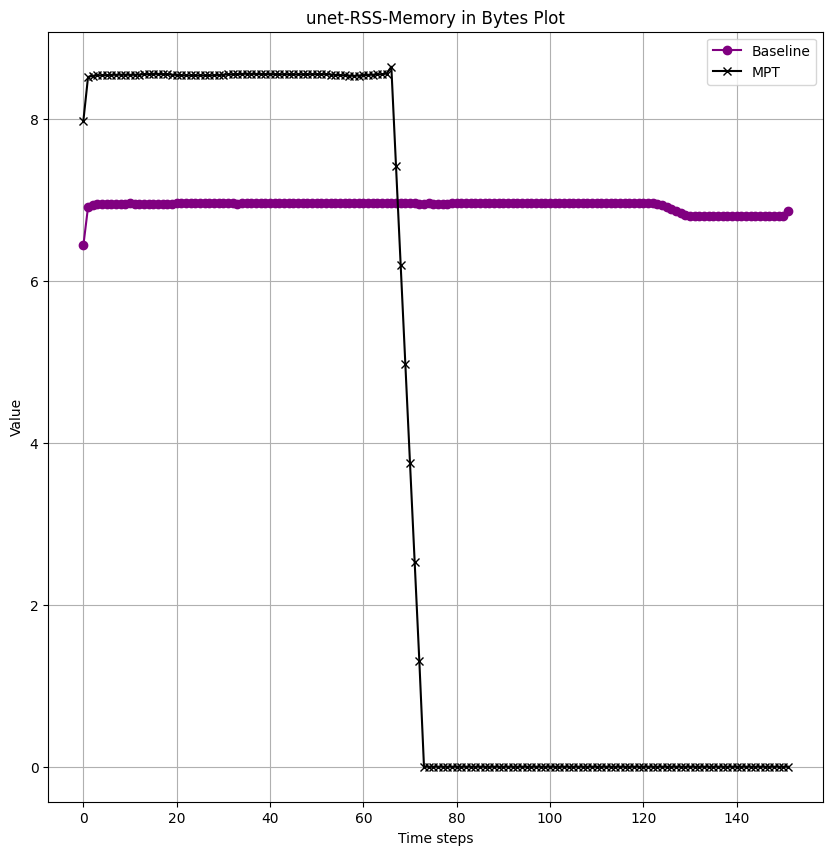

1087.1853124999996 618.7786291666667
convlstm Baseline
convlstm MPT
33 35
35 35


C:\Users\fe-na\AppData\Local\Temp\ipykernel_28576\899686154.py:63: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = scipy.integrate.simps(arr, x=None, dx=1,axis=-1, even='avg')


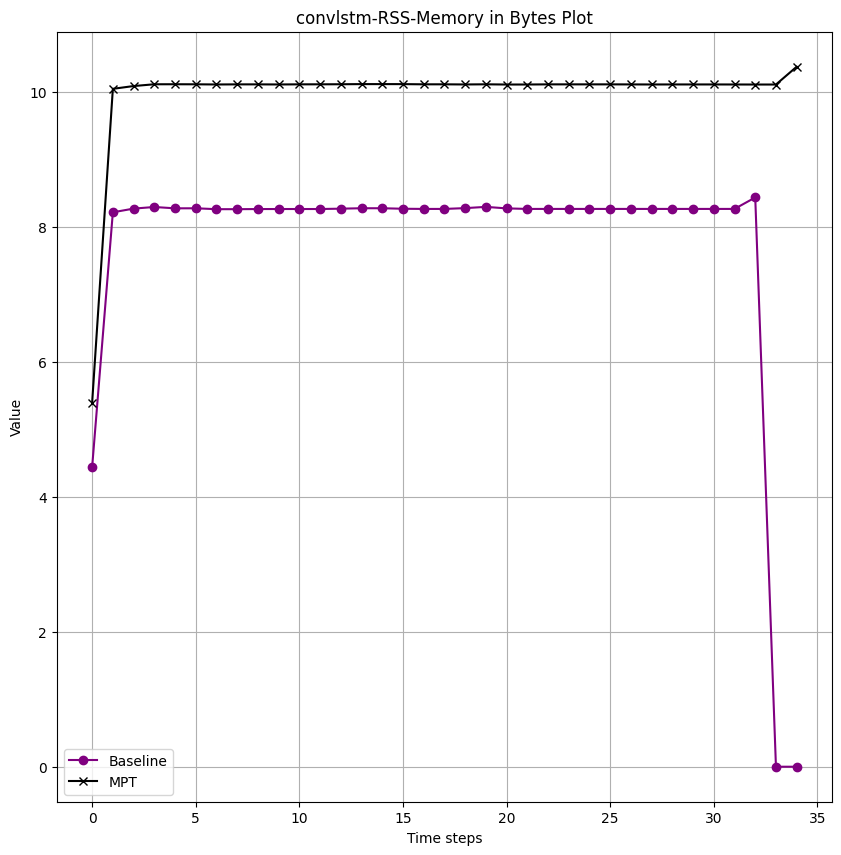

266.191175 342.2456516666667
climax_frozen Baseline
climax_frozen MPT
333 227
333 333


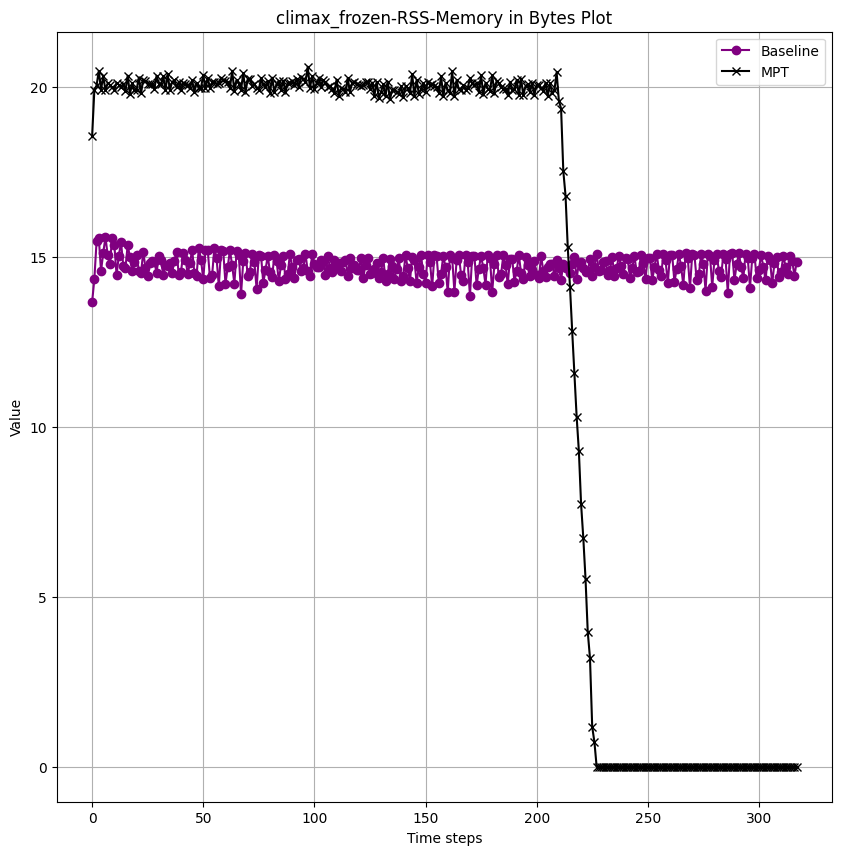

4884.241705 4513.774183333333
climax Baseline
climax MPT
475 363
475 475


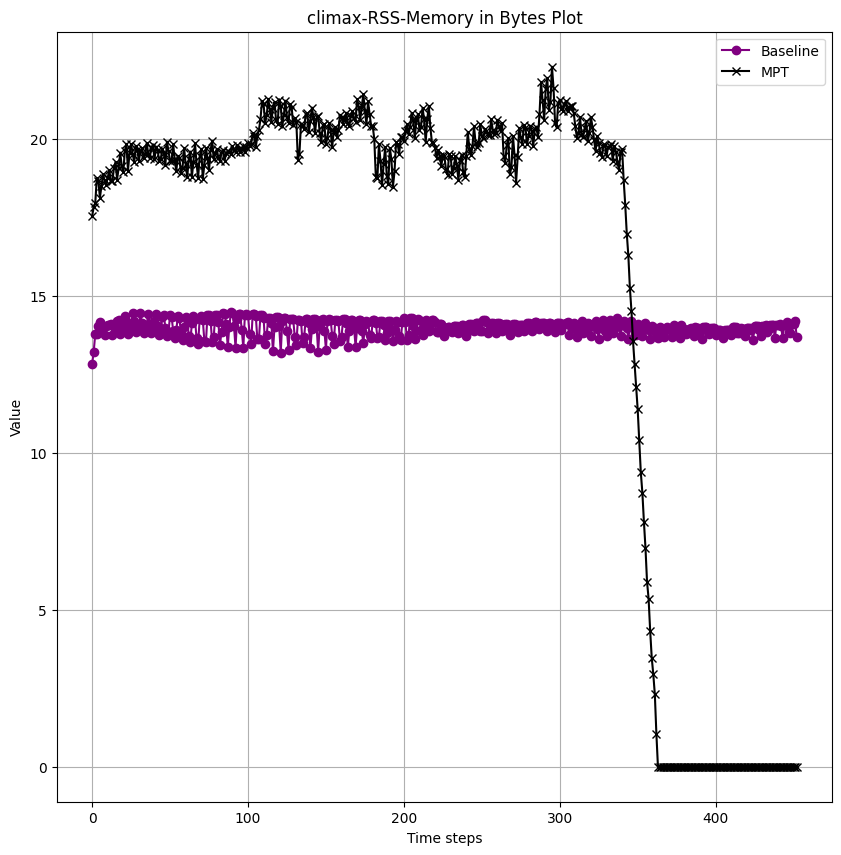

6609.082451666666 7194.6470850000005


In [49]:

from scipy import stats
import scipy
import matplotlib.patches as mpatches

keyword = "RSS-Memory in GB"
#keyword = "GPU_Memory in GB"

unit = "Bytes"


def smooth_array(array, factor=0.05):
    """
    Applies a moving average to smooth the array.

    Parameters:
    array (list or np.array): The array to smooth.
    factor (float): The smoothing factor. Determines the window size.

    Returns:
    np.array: The smoothed array.
    """
    window_size = int(len(array) * factor)
    if window_size < 1:
        window_size = 1
    smoothed_array = np.convolve(array, np.ones(window_size)/window_size, mode='valid')
    return smoothed_array

def plot_arrays(array1, array2, label_1='Array 1', label_2='Array 2', title="Plot", unit="value"):
    """
    Plots two smoothed arrays on a single diagram with a purple and black color scheme.

    Parameters:
    array1 (list or np.array): The first array to plot.
    array2 (list or np.array): The second array to plot.
    label_1 (str): Label for the first array.
    label_2 (str): Label for the second array.

    Returns:
    None
    """
    smoothed_array1 = smooth_array(array1)
    smoothed_array2 = smooth_array(array2)

    plt.figure(figsize=(10, 10))
    title = title.replace("GB", "Bytes")

    plt.plot(smoothed_array1, label=label_1, marker='o', color='#662E7D')
    plt.plot(smoothed_array2, label=label_2, marker='x', color='black')

    plt.xlabel('Time steps')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"figures/RQ_2.3/{title}.png")
    plt.show()

def integral_below_curve(arr):
    # Calculate the width of each interval
    dx = 1  # Assuming the intervals are of unit width

    # Use the trapezoidal rule for numerical integration
    integral = scipy.integrate.simps(arr, x=None, dx=1,axis=-1, even='avg')
    #integral = np.trapz(arr, dx=dx)
    return integral

data_list_rank_sum = []
already_used_name=[]
arr_of_integrals = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]
        print(run[0], treatment_0)
        print(run[0], treatment_1)
        
        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)[keyword]
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)[keyword]
        big_len = len(data_for_run_0)
        print(big_len, len(data_for_run_1))
        if(len(data_for_run_0)>len(data_for_run_1)):
            pad = len(data_for_run_0) - len(data_for_run_1)
            data_for_run_1 = data_for_run_1 + [0] * (pad)
        else: 
            pad = len(data_for_run_1) - len(data_for_run_0)
            data_for_run_0 = data_for_run_0 + [0] * (pad)

        print(len(data_for_run_0),len(data_for_run_1))

        plot_arrays(data_for_run_0,data_for_run_1, treatment_0,treatment_1,f"{name}-{keyword} Plot", unit)

        # Calculate the integrals below the curves
        integral1 = integral_below_curve(data_for_run_0)
        integral2 = integral_below_curve(data_for_run_1)
        print(integral1,integral2)
        arr_of_integrals.append({f"{name}-{treatment_0}":integral1, f"{name}-{treatment_1}":integral2})
        # SWT_CPU = stats.spearmanr(gpu_0, gpu_1)

       

        # data_list_rank_sum.append({
        #     "Name": name,
        #     "GPU-Statistic-RS": SWT_GPU.statistic,
        #     "GPU-P-RS": SWT_GPU.pvalue,
        # })


[1087.1853124999996, 618.7786291666667, 266.191175, 342.2456516666667, 4884.241705, 4513.774183333333, 6609.082451666666, 7194.6470850000005]
['climax-Baseline', 'climax-MPT', 'climax_frozen-Baseline', 'climax_frozen-MPT', 'convlstm-Baseline', 'convlstm-MPT', 'unet-Baseline', 'unet-MPT'] 
 [6609.082451666666, 7194.6470850000005, 4884.241705, 4513.774183333333, 266.191175, 342.2456516666667, 1087.1853124999996, 618.7786291666667]
['climax', 'climax*', 'climax_frozen', 'climax_frozen*', 'convlstm', 'convlstm*', 'unet', 'unet*']


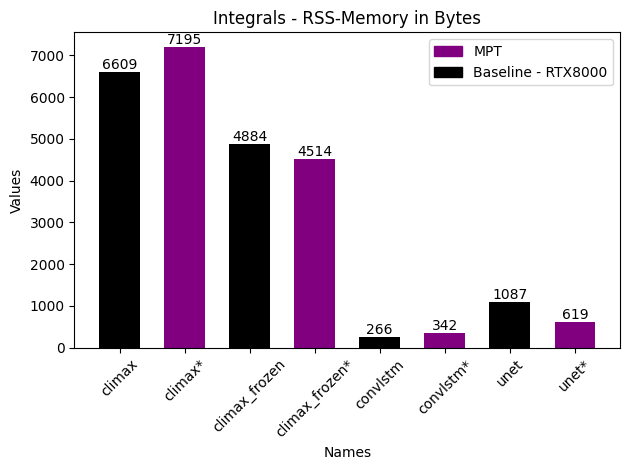

In [50]:

# Extracting the treatment names and integrals
t_val = list((d.keys() for d in arr_of_integrals))
t_val = [key for keys in t_val for key in keys]

integrals = list((d.values() for d in arr_of_integrals))
integrals = [val for vals in integrals for val in vals]
print(integrals)
list1, list2 = zip(*sorted(zip(t_val, integrals)))
treatments_sorted, integrals_sorted = (list(t) for t in zip(*sorted(zip(list1, list2))))
print(treatments_sorted,"\n",integrals_sorted)
# Step 1: Remove everything after the hyphen
step1_result = [s.split('-')[0] for s in treatments_sorted]

# Step 2: Attach '*' to every second string
step2_result = [s + '*' if i % 2 == 1 else s for i, s in enumerate(step1_result)]


x = range(len(arr_of_integrals))
width = 0.35
# Define the width of each bar and the spacing between bars
bar_width = 0.5  # Adjust as needed
bar_spacing = 0.3  # Adjust as needed
print(step2_result)
# Define colors for every 2 values
colors = ['black', '#662E7D'] * (len(integrals_sorted) // 2)

# Define the width of each bar and the spacing between bars
bar_width = 0.5  # Adjust as needed
bar_spacing = 0.3  # Adjust as needed

# Plot the bars
bars = plt.bar(np.arange(len(step2_result)) * (bar_width + bar_spacing), integrals_sorted, color=colors, width=bar_width)

# Annotate each bar with its value
for bar, value in zip(bars, integrals_sorted):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(value)),
             ha='center', va='bottom')
# Create custom legend
legend_handles = [mpatches.Patch(color='#662E7D', label='MPT'),
                  mpatches.Patch(color='black', label='Baseline - RTX8000')]
plt.legend(handles=legend_handles)

# Adding labels and title
plt.xlabel('Names')
plt.ylabel('Values')
plt.title(f"Integrals - {keyword.replace('GB','Bytes')}")
plt.xticks(np.arange(len(step2_result)) * (bar_width + bar_spacing), step2_result, rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.savefig(f"figures/RQ_2.3_Integral/Integral_Plot_{keyword.replace('GB','Bytes')}.png")



In [51]:
newdfforthis = pd.DataFrame(arr_of_integrals)

# Split column names and extract the first part as the treatment
names = list(set(newdfforthis.columns.str.split('-').str[0]))
newdfforthis['names'] = names

# Reorder the columns with 'treatment' as the first column
cols = ['names'] + [col for col in newdfforthis.columns if col != 'names']
data = newdfforthis[cols]

df = pd.DataFrame(data)

# Extract Baseline and A100 columns for each treatment
baseline_cols = [col for col in df.columns if 'Baseline' in col]
A100_cols = [col for col in df.columns if 'MPT' in col]

# Create new columns for Baseline and A100
df['Baseline'] = df[baseline_cols].sum(axis=1)
df['MPT'] = df[A100_cols].sum(axis=1)

# Drop the old treatment-specific columns
df.drop(columns=baseline_cols + A100_cols, inplace=True)
# Add a new column "Treatment"
df['Treatment'] = df.apply(lambda row: 'Baseline' if 'Baseline' in row['names'] else 'MPT', axis=1)
# Melt the DataFrame to combine the "RTX8000_GPU" and "A100_GPU" columns into one column called "GPU"
df = pd.melt(df, id_vars=['names', 'Treatment'], var_name='GPU', value_name='value')
df.drop(columns=['Treatment'], inplace=True)
# Rename the columns
df.rename(columns={'GPU': 'Treatment', 'value': 'GPU Memory'}, inplace=True)
df.rename(columns={'names': 'Name'}, inplace=True)
df["GPU Memory"] = df["GPU Memory"].dropna().round().astype(int)


selected_columns = ['Name', 'Treatment', 'Time/Train Mean_Minutes', "Min_RMSE"]
shrunken_df = sorted_df[selected_columns].copy()
shrunken_df['Treatment'] = shrunken_df['Treatment']
merged_df_summary = pd.merge(df, shrunken_df, on=['Name', 'Treatment'])
merged_df_summary = merged_df_summary.sort_values(by=['Name']).reset_index(drop=True)

print(merged_df_summary,"\n")
# Remove the "Treatment" column


            Name Treatment  GPU Memory  Time/Train Mean_Minutes  Min_RMSE
0         climax  Baseline        4884                    2.366     1.171
1         climax       MPT        4514                    1.823     1.183
2  climax_frozen  Baseline         266                    1.691     0.632
3  climax_frozen       MPT         342                    1.213     0.673
4       convlstm  Baseline        6609                    0.217     0.551
5       convlstm       MPT        7195                    0.182     0.555
6           unet  Baseline        1087                    0.784     1.241
7           unet       MPT         619                    0.386     1.151 



            Name Treatment  GPU Memory  Time/Train Mean_Minutes  Min_RMSE
0         climax  Baseline        4884                    2.366     1.171
1         climax       MPT        4514                    1.823     1.183
2  climax_frozen  Baseline         266                    1.691     0.632
3  climax_frozen       MPT         342                    1.213     0.673
4       convlstm  Baseline        6609                    0.217     0.551
5       convlstm       MPT        7195                    0.182     0.555
6           unet  Baseline        1087                    0.784     1.241
7           unet       MPT         619                    0.386     1.151


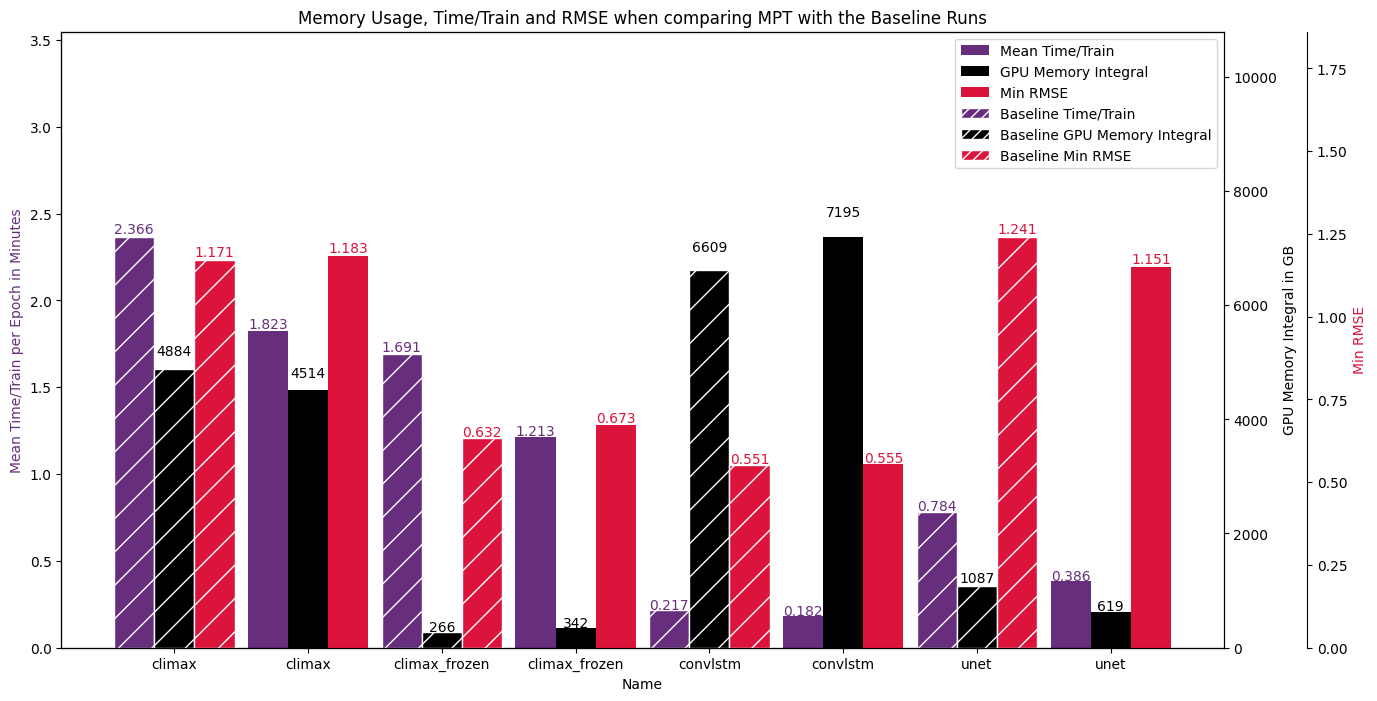

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your dataframe
df = merged_df_summary
print(df)

# Set up the plot
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot the Time/Train Mean_Minutes with dashed bars for Treatment == 2
ax1.set_xlabel('Name')
ax1.set_ylabel('Mean Time/Train per Epoch in Minutes', color='#662E7D')
bars1 = ax1.bar(df.index - 0.3, df['Time/Train Mean_Minutes'], width=0.3, label='Mean Time/Train per Epoch in Minutes', color='#662E7D')
for i, bar in enumerate(bars1):
    if df['Treatment'][i] == "Baseline":
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Create a second y-axis for GPU Memory
ax2 = ax1.twinx()
ax2.set_ylabel('GPU Memory Integral in GB', color='black')
bars2 = ax2.bar(df.index, df['GPU Memory'], width=0.3, label='GPU Memory Integral', color='black')
for i, bar in enumerate(bars2):
    if df['Treatment'][i] == "Baseline":
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Create a third y-axis for Min_RMSE
ax3 = ax1.twinx()
# Move the third y-axis spine to the right
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Min RMSE', color='crimson')
bars3 = ax3.bar(df.index + 0.3, df['Min_RMSE'], width=0.3, label='Min RMSE', color='crimson')
for i, bar in enumerate(bars3):
    if df['Treatment'][i] == "Baseline":
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Adding names as x-axis labels
ax1.set_xticks(df.index)
ax1.set_xticklabels(df['Name'])

# Annotate the bars with Treatment values
for i in range(len(df)):
    ax1.text(df.index[i] - 0.3, df['Time/Train Mean_Minutes'][i] * 1.01, str(df['Time/Train Mean_Minutes'][i]), ha='center', color='#662E7D')
    ax2.text(df.index[i], df['GPU Memory'][i]* 1.05, str(df['GPU Memory'][i]), ha='center', color='black')
    ax3.text(df.index[i] + 0.3, df['Min_RMSE'][i] * 1.01, str(df['Min_RMSE'][i]), ha='center', color='crimson')

# Add legend with grouped labels
purple_patch = plt.Rectangle((0, 0), 1, 1, fc="#662E7D", hatch="")
black_patch = plt.Rectangle((0, 0), 1, 1, fc="black", hatch="")
crimson_patch = plt.Rectangle((0, 0), 1, 1, fc="crimson", hatch="")
dashed_purple_patch = plt.Rectangle((0, 0), 1, 1, fc="#662E7D", edgecolor="white", hatch="///")
dashed_black_patch = plt.Rectangle((0, 0), 1, 1, fc="black", edgecolor="white", hatch="///")
dashed_crimson_patch = plt.Rectangle((0, 0), 1, 1, fc="crimson", edgecolor="white", hatch="///")

plt.legend(handles=[purple_patch, black_patch, crimson_patch, dashed_purple_patch, dashed_black_patch, dashed_crimson_patch],
           labels=['Mean Time/Train', 'GPU Memory Integral', 'Min RMSE', 'Baseline Time/Train', 'Baseline GPU Memory Integral', 'Baseline Min RMSE'], loc='upper right')

# Adjust y-axis limits to add more whitespace upwards
max_time_train = df['Time/Train Mean_Minutes'].max()
max_GPU_Memory = df['GPU Memory'].max()
max_min_rmse = df['Min_RMSE'].max()

ax1.set_ylim(0, max_time_train * 1.5)
ax2.set_ylim(0, max_GPU_Memory * 1.5)
ax3.set_ylim(0, max_min_rmse * 1.5)

plt.title('Memory Usage, Time/Train and RMSE when comparing MPT with the Baseline Runs')

# Save the figure
fig.savefig("figures/RQ_2.3_combined_bar/RQ_2.3_combined_bar.png")

# Show plot
plt.show()

